In [485]:
import networkx as nx
import pandas as pd
import geopandas as gpd
import config as cfg
import numpy as np
import matplotlib.pyplot as plt
from utils import build_trip_count, get_district_names, normalize_by_pop, get_income_data, add_quantiles

In [486]:
all_viajes = pd.read_csv('/Users/caro/Desktop/thesis_project/mobility_data/VIAJES/all_viajes_month_0322.csv') # all trips
income = gpd.read_file('/Users/caro/Desktop/thesis_project/segregation_indices/data/processed/geometries_and_income.geojson') # income data
gdf = gpd.read_file(cfg.ZONIFICACION_DATA / 'distritos/madrid_gdf.geojson') # geodataframe
# gdf = gdf.to_crs(epsg=4326)
district_mapping = pd.read_csv('/Users/caro/Desktop/thesis_project/data_overview/outputs/districts_and_population.csv')

In [487]:
all_viajes.actividad_destino.value_counts()

actividad_destino
frecuente          7268863
casa               4933456
no_frecuente       4920539
trabajo_estudio    2778097
Name: count, dtype: int64

In [488]:
all_viajes.head()

,fecha,periodo,origen,destino,distancia,actividad_origen,actividad_destino,estudio_origen_posible,estudio_destino_posible,residencia,renta,edad,sexo,viajes,viajes_km
0,20220301,0,2807901,2807901,0.5-2,casa,frecuente,no,no,28,>15,0-25,hombre,29.337,30.222
1,20220301,0,2807901,2807901,0.5-2,casa,frecuente,no,no,28,>15,0-25,mujer,34.143,27.522
2,20220301,0,2807901,2807901,0.5-2,casa,frecuente,no,no,28,>15,25-45,hombre,92.799,63.331
3,20220301,0,2807901,2807901,0.5-2,casa,frecuente,no,no,28,>15,25-45,mujer,65.475,44.556
4,20220301,0,2807901,2807901,0.5-2,casa,frecuente,no,no,28,>15,45-65,hombre,44.319,31.052


In [489]:
filtered_df = all_viajes.loc[(all_viajes['actividad_origen'] == 'casa')] # home origin trips

In [490]:
filtered_df.shape

(4839108, 15)

In [491]:
home_work = all_viajes[ # home to work trips
    ((all_viajes['actividad_origen'] == 'casa') & (all_viajes['actividad_destino'] == 'trabajo_estudio'))
]

In [492]:
home_work.shape

(1205740, 15)

## Filtering trips by median income quantile

1. Do low median income quantiles travel more to high median income quantiles for work purposes and overall?
2. Do low median income quantiles travel more distance on average than other median income quantiles for work purposes and overall?

Question 1, all trips with home origin:

In [493]:
district_counts = filtered_df['origen'].value_counts().reset_index() # counting total trops from origin based on district
district_counts.columns = ['ID', 'Population']

In [494]:
trip_counts = build_trip_count(filtered_df)
trip_counts = get_district_names(trip_counts)
trip_counts = normalize_by_pop(trip_counts, district_counts)
trip_counts = get_income_data(trip_counts, income, 'Gini Index', 'Median income per consumption unit')
trip_counts = add_quantiles(trip_counts, 'Median income per consumption unit', n_quantiles=4)
trip_counts = add_quantiles(trip_counts, 'Gini Index', n_quantiles=4)

In [495]:
low_to_high_median = trip_counts[(trip_counts['income decile origin Median income per consumption unit'].isin([0, 1])) & 
                                      (trip_counts['income decile destination Median income per consumption unit'].isin([2, 3]))]

high_to_low_median = trip_counts[(trip_counts['income decile origin Median income per consumption unit'].isin([2, 3])) & 
                                      (trip_counts['income decile destination Median income per consumption unit'].isin([0, 1]))]

low_to_low_median = trip_counts[(trip_counts['income decile origin Median income per consumption unit'].isin([0, 1])) &
                                (trip_counts['income decile destination Median income per consumption unit'].isin([0, 1]))]

high_to_high_median = trip_counts[(trip_counts['income decile origin Median income per consumption unit'].isin([2, 3])) & 
                                trip_counts['income decile destination Median income per consumption unit'].isin([2, 3])]

In [496]:
# percentage of trips from low to high districts (median income per consumtion unit)
# low_to_high_median['trip_count'].sum() / trip_counts.trip_count.sum() * 100

low_to_high_median['normalized_trip_count'].sum() / trip_counts.normalized_trip_count.sum() * 100

np.float64(24.05383469466257)

In [497]:
# percentage of trips from high to low districts (median income per consumtion unit)
# high_to_low_median['trip_count'].sum() / trip_counts.trip_count.sum() * 100

high_to_low_median['normalized_trip_count'].sum() / trip_counts.normalized_trip_count.sum() * 100

np.float64(16.692135748232396)

In [498]:
# low_to_low_median['trip_count'].sum() / trip_counts.trip_count.sum() * 100 

low_to_low_median['normalized_trip_count'].sum() / trip_counts.normalized_trip_count.sum() * 100

np.float64(28.327117686289817)

In [499]:
# high_to_high_median['trip_count'].sum() / trip_counts.trip_count.sum() * 100 

high_to_high_median['normalized_trip_count'].sum() / trip_counts.normalized_trip_count.sum() * 100

np.float64(30.92691187081523)

Question 2, all trips with home origin:

In [500]:
trip_counts = build_trip_count(filtered_df, 'distancia') # adding 'distancia' to the analysis
trip_counts = get_district_names(trip_counts)
trip_counts = normalize_by_pop(trip_counts, district_counts)
trip_counts = get_income_data(trip_counts, income, 'Gini Index', 'Median income per consumption unit')
trip_counts = add_quantiles(trip_counts, 'Median income per consumption unit', n_quantiles=4)
trip_counts = add_quantiles(trip_counts, 'Gini Index', n_quantiles=4)

In [501]:
low_median_income = trip_counts[trip_counts['income decile origin Median income per consumption unit'].isin([0, 1])]
high_median_income = trip_counts[trip_counts['income decile origin Median income per consumption unit'].isin([2, 3])]

In [502]:
low_income_normalized_sums = low_median_income.groupby("distancia")["normalized_trip_count"].sum() # summing normalized trip count by distance (numerator)
low_income_total = low_income_normalized_sums.sum() # summing all trip counts by distance (getting the total to be the denominator)
low_income_proportions = (low_income_normalized_sums / low_income_total).reset_index()
low_income_proportions.columns = ["distance_bracket", "Low Income"]

high_income_normalized_sums = high_median_income.groupby("distancia")["normalized_trip_count"].sum()
high_income_total = high_income_normalized_sums.sum() 
high_income_proportions = (high_income_normalized_sums / high_income_total).reset_index()
high_income_proportions.columns = ["distance_bracket", "High Income"]

comparison_normalized_median = pd.merge(
    low_income_proportions, 
    high_income_proportions, 
    on="distance_bracket", 
    how="outer"
)

In [503]:
distance_order = ['0.5-2', '2-10', '10-50']
colors = ["#ffc0cb", "#800080"]

# reindexing for plotting
comparison_normalized_median = comparison_normalized_median.set_index('distance_bracket')
comparison_normalized_median = comparison_normalized_median.reindex(distance_order)
comparison_normalized_median = comparison_normalized_median.reset_index()

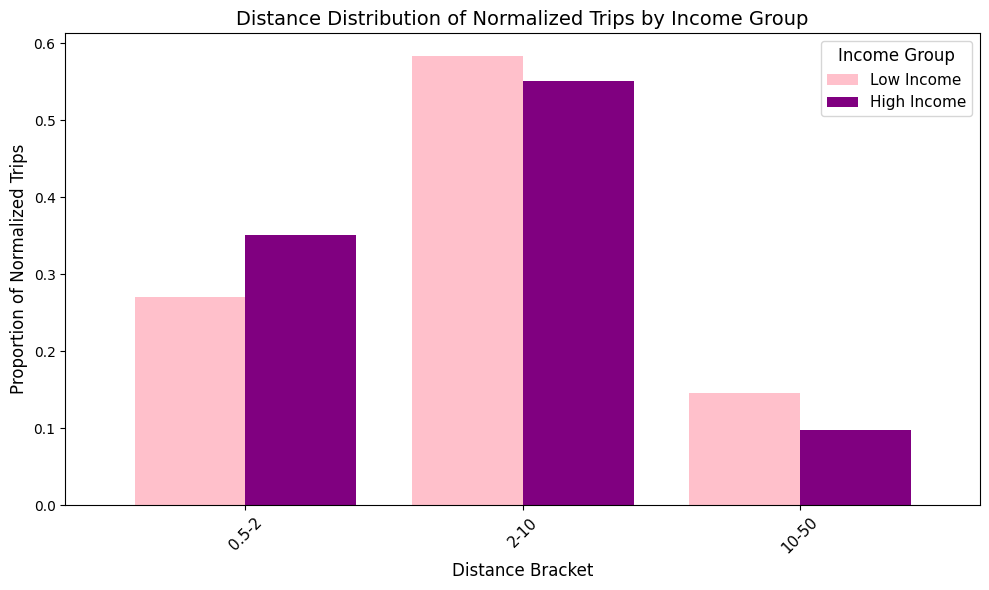

In [504]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting the comparison dataframe with normalized trip shares
comparison_normalized_median.plot(
    x='distance_bracket',  # Set x-axis as distance bracket
    kind='bar', 
    ax=ax, 
    color=colors,
    width=0.8  # Adjust bar width
)

plt.title('Distance Distribution of Normalized Trips by Income Group', fontsize=14)
plt.xlabel('Distance Bracket', fontsize=12)
plt.ylabel('Proportion of Normalized Trips', fontsize=12)
plt.xticks(rotation=45, fontsize=11)  # Rotate x-axis labels for better readability
plt.legend(title='Income Group', fontsize=11, title_fontsize=12)
plt.tight_layout()  
plt.savefig('figures/median_distance_distribution.png')  # Save the plot
plt.show()  

## Filtering trips by Gini Index quantile

Question 1, all trips with home origin, Gini Index:

In [505]:
trip_counts = build_trip_count(filtered_df)
trip_counts = get_district_names(trip_counts)
trip_counts = normalize_by_pop(trip_counts, district_counts)
trip_counts = get_income_data(trip_counts, income, 'Gini Index', 'Median income per consumption unit')
trip_counts = add_quantiles(trip_counts, 'Median income per consumption unit', n_quantiles=4)
trip_counts = add_quantiles(trip_counts, 'Gini Index', n_quantiles=4)

In [506]:
low_to_high_gini = trip_counts[(trip_counts['income decile origin Gini Index'].isin([0, 1])) & 
                                      (trip_counts['income decile destination Gini Index'].isin([2, 3]))]

high_to_low_gini = trip_counts[(trip_counts['income decile origin Gini Index'].isin([2, 3])) & 
                                      (trip_counts['income decile destination Gini Index'].isin([0, 1]))]

low_to_low_gini = trip_counts[(trip_counts['income decile origin Gini Index'].isin([0, 1])) &
                              (trip_counts['income decile destination Gini Index'].isin([0, 1]))]


high_to_high_gini = trip_counts[(trip_counts['income decile origin Gini Index'].isin([2, 3])) & 
                                (trip_counts['income decile destination Gini Index'].isin([2, 3]))]

In [507]:
# percentage of trips from low to high districts (gini index)
# low_to_high_gini['trip_count'].sum() / trip_counts.trip_count.sum() * 100 

low_to_high_gini['normalized_trip_count'].sum() / trip_counts.normalized_trip_count.sum() * 100 

np.float64(22.855419597719326)

In [508]:
# percentage of trips from high to low districts (gini index)
# high_to_low_gini['trip_count'].sum() / trip_counts.trip_count.sum() * 100 

high_to_low_gini['normalized_trip_count'].sum() / trip_counts.normalized_trip_count.sum() * 100 

np.float64(14.016069716762885)

In [509]:
# low_to_low_gini['trip_count'].sum() / trip_counts.trip_count.sum() * 100 

low_to_low_gini['normalized_trip_count'].sum() / trip_counts.normalized_trip_count.sum() * 100 

np.float64(29.52553278323306)

In [510]:
# high_to_high_gini['trip_count'].sum() / trip_counts.trip_count.sum() * 100 

high_to_high_gini['normalized_trip_count'].sum() / trip_counts.normalized_trip_count.sum() * 100 

np.float64(33.602977902284735)

Question 2, all trips with home origin, Gini Index:

In [511]:
trip_counts = build_trip_count(filtered_df, 'distancia')
trip_counts = get_district_names(trip_counts)
trip_counts = normalize_by_pop(trip_counts, district_counts)
trip_counts = get_income_data(trip_counts, income, 'Gini Index', 'Median income per consumption unit')
trip_counts = add_quantiles(trip_counts, 'Median income per consumption unit', n_quantiles=4)
trip_counts = add_quantiles(trip_counts, 'Gini Index', n_quantiles=4)

In [512]:
low_gini = trip_counts[trip_counts['income decile origin Gini Index'].isin([0, 1])]
high_gini = trip_counts[trip_counts['income decile origin Gini Index'].isin([2, 3])]

In [513]:
low_gini_normalized_sums = low_gini.groupby("distancia")["normalized_trip_count"].sum() # summing normalized trip count by distance (numerator)
low_gini_total = low_gini_normalized_sums.sum() # summing all trip counts by distance (getting the total to be the denominator)
low_gini_proportions = (low_gini_normalized_sums / low_gini_total).reset_index()
low_gini_proportions.columns = ["distance_bracket", "Low Gini"]

high_gini_normalized_sums = high_gini.groupby("distancia")["normalized_trip_count"].sum()
high_gini_total = high_gini_normalized_sums.sum() 
high_gini_proportions = (high_gini_normalized_sums / high_gini_total).reset_index()
high_gini_proportions.columns = ["distance_bracket", "High Gini"]

comparison_normalized_gini = pd.merge(
    low_gini_proportions, 
    high_gini_proportions, 
    on="distance_bracket", 
    how="outer"
)

In [514]:
distance_order = ['0.5-2', '2-10', '10-50']
colors = ["#ffc0cb", "#800080"]

# reindexing for plotting
comparison_normalized_gini = comparison_normalized_gini.set_index('distance_bracket')
comparison_normalized_gini = comparison_normalized_gini.reindex(distance_order)
comparison_normalized_gini = comparison_normalized_gini.reset_index()

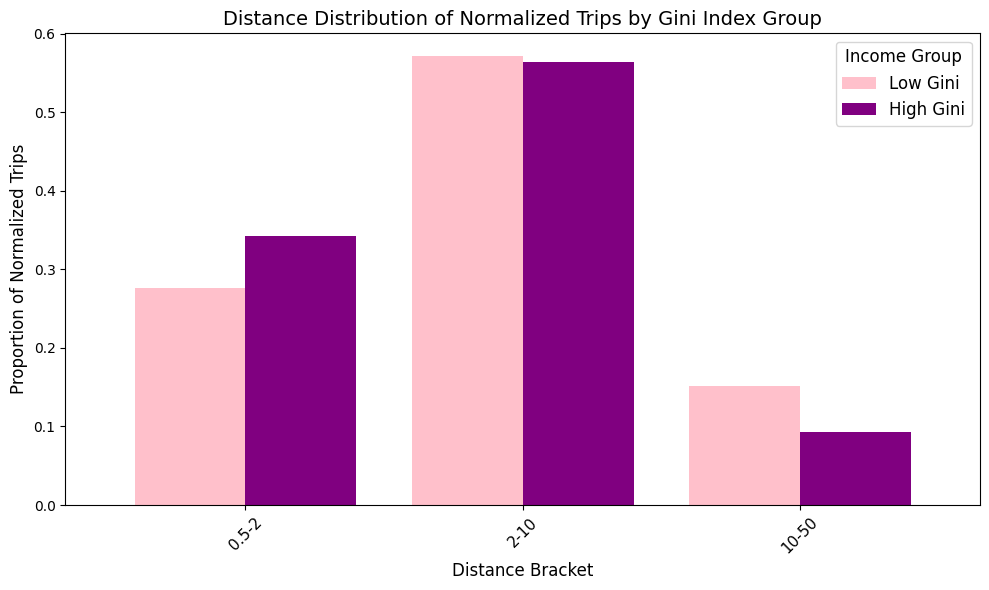

In [515]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting the comparison dataframe with normalized trip shares
comparison_normalized_gini.plot(
    x='distance_bracket',  # Set x-axis as distance bracket
    kind='bar', 
    ax=ax, 
    color=colors,
    width=0.8  # Adjust bar width
)

plt.title('Distance Distribution of Normalized Trips by Gini Index Group', fontsize=14)
plt.xlabel('Distance Bracket', fontsize=12)
plt.ylabel('Proportion of Normalized Trips', fontsize=12)
plt.xticks(rotation=45, fontsize=11)  # Rotate x-axis labels for better readability
plt.legend(title='Income Group', fontsize=12, title_fontsize=12)
plt.tight_layout()  
plt.savefig('figures/gini_distance_distribution.png')  # Save the plot
plt.show()  

## Further Analysis

In [516]:
comparison_normalized_median["Difference (%)"] = (comparison_normalized_median["High Income"] - comparison_normalized_median["Low Income"]) * 100

In [517]:
comparison_normalized_median

,distance_bracket,Low Income,High Income,Difference (%)
0,0.5-2,0.269998,0.350427,8.042817
1,2-10,0.583898,0.551729,-3.216857
2,10-50,0.146104,0.097844,-4.825960


In [519]:
comparison_normalized_gini["Difference (%)"] = (comparison_normalized_gini["High Gini"] - comparison_normalized_gini["Low Gini"]) * 100

In [520]:
comparison_normalized_gini

,distance_bracket,Low Gini,High Gini,Difference (%)
0,0.5-2,0.276931,0.342801,6.586991
1,2-10,0.572121,0.564684,-0.743671
2,10-50,0.150948,0.092515,-5.843320


In [522]:
comparison_normalized_gini.to_latex()

'\\begin{tabular}{llrrr}\n\\toprule\n & distance_bracket & Low Gini & High Gini & Difference (%) \\\\\n\\midrule\n0 & 0.5-2 & 0.276931 & 0.342801 & 6.586991 \\\\\n1 & 2-10 & 0.572121 & 0.564684 & -0.743671 \\\\\n2 & 10-50 & 0.150948 & 0.092515 & -5.843320 \\\\\n\\bottomrule\n\\end{tabular}\n'